# Single-Order Spectrum

This will show how to fit a single-order spectrum using our [previous setup](setup.ipynb) on some archived IRTF data. The spectrum we will be looking at is HD 213135.

<div class="alert alert-warning">
    
**Warning:** This documentation is a work in progress, please be aware this will change rapidly. 

</div>

## Preprocessing

So the first thing we need to do is pre-process our data. Here we loud the original dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.io import fits
import astropy.units as u

url = "/Users/miles/dev/starfish_playground/data/IRTF_Debris_Disk_Reduced_Spectra copy/hd109085_sxd_xcleanspec_120203.fits"
raw_data, header = fits.getdata(url, header=True)

In [3]:
header

SIMPLE  =                    T / Written by IDL:  Wed Mar 21 13:01:08 2012      
BITPIX  =                  -32 /Real*4 (floating point)                         
NAXIS   =                    2 /                                                
NAXIS1  =                 4165 /Number of positions along axis 1                
NAXIS2  =                    3 /Number of positions along axis 2                
ORIGIN  = 'Institute for Astronomy' /                                           
TELESCOP= 'NASA IRTF'          /                                                
INSTRUME= 'SPeX, IRTF Spectrograph' /                                           
OBSERVER= 'Your_Name'          /                                                
OBJECT  = 'HD109085'           /                                                
IRAFNAME= 'hd109085_sxd_xmergeorders' /                                         
TIME_OBS= '13:37:5.0983265'    / Average UT TIME OF ACQISTION ('hh:mm:ss.ss')   
DATE_OBS= '2012-02-03'      

In [4]:
wave = raw_data[0] * u.Unit("um")
flux = raw_data[1] * u.Unit("W m-2 um-1")
sigma = raw_data[2] * u.Unit("W m-2 um-1")

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("seaborn")
plt.rcParams["text.usetex"] = True

In [7]:
import numpy as np
from Starfish.spectrum import Spectrum

w = np.double(wave.to("AA").data)
f = np.double(flux.to("erg s-1 cm-2 cm-1").data)
s = np.double(sigma.to("erg s-1 cm-2 cm-1").data)
mask = np.isfinite(f) & (wave > 0.9 * u.um)

data = Spectrum(w, f, s, mask, name="HD 109085")
data.save("HD109085.hdf5")

And lets take a look at our data

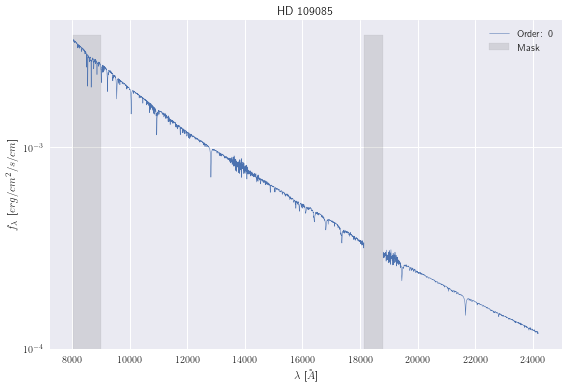

In [8]:
data.plot();

## Setting up the model

Now we can set up our initial model. We need, at minimum, an emulator, our data, and a set of the library grid parameters. Every extra keyword argument we add is added to our list of parameters. For more information on what parameters are available and what effect they have, see the [SpectrumModel documentation](../api/models.rst#SpectrumModel).

Some of these parameters are based on guesses or pre-existing knowledge. In particular, it's important to tune `log_scale` to a reasonable value, so take some iterations of plotting against the data to get a good starting point. We also want our `global_cov:log_amp` to be reasonable, so pay attention to the $\sigma$-contours in the residuals plots, too.

Starting with the [Simbad entry for our star](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=HD+87822+%09&submit=SIMBAD+search) we track down some good initial values. In particular, [this paper](https://ui.adsabs.harvard.edu/abs/2011A%26A...531A.165P/abstract) has reasonable values, plus we can use information from the FITS header (provided by [Rayner, J.T., Cushing, M.C., & Vacca (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJS..185..289R/abstract))

In [9]:
from Starfish.models import SpectrumModel

model = SpectrumModel(
    "F_SPEX_emu.hdf5",
    data,
    grid_params=[6784, 4.06, 0],
    Av=0,
    global_cov=dict(log_amp=25, log_ls=10),
)
model

SpectrumModel
-------------
Data: HD 109085
Emulator: F_SPEX_emu
Log Likelihood: None

Parameters
  Av: 0
  T: 6784
  Z: 0
  global_cov:
    log_amp: 25
    log_ls: 10
  logg: 4.06

In this plot, we can see the data and model in the left pane, the absolute errors (residuals) along with the diagonal of the covariance matrix as $\sigma$ contours in the top-right, and the relative errors (residuals / flux) in the bottom-right

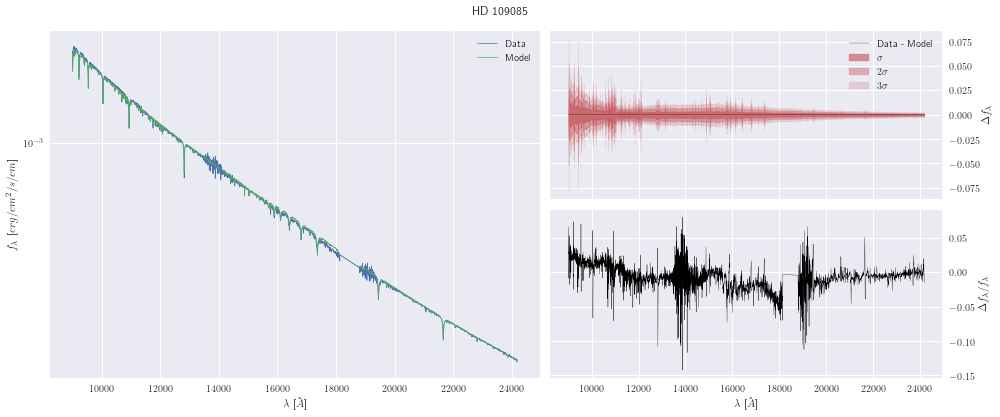

In [10]:
model.plot();

## Numerical Optimization

Now lets do a *maximum a posteriori* (MAP) point estimate for our data. 


Here we freeze `logg` here because the PHOENIX models' response to `logg` compared to our data are relatively flat, so we fix the value using the [freeze](../api/models.rst#parametrization) mechanics. This is equivalent to applying a $\delta$-function prior.

In [11]:
# These are the fittable parameters
model.freeze("logg")
model.labels

('Av', 'T', 'Z', 'global_cov:log_amp', 'global_cov:log_ls')

In [15]:
import scipy.stats as st

priors = {
    "T": st.uniform(6200, 800),
    "logg": st.uniform(4.0, 0.3),
    "Z": st.uniform(0, 0.3),
    "Av": st.uniform(0, 2),
}

In [16]:
%timeit model.log_likelihood(priors)

1.56 s ± 51.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%time model.train(priors)

CPU times: user 25min 39s, sys: 7min 59s, total: 33min 39s
Wall time: 15min 13s


 final_simplex: (array([[7.24490108e-02, 7.00000000e+03, 2.99998968e-01, 3.17570233e+01,
        2.20522047e+02],
       [7.24490165e-02, 6.99999999e+03, 2.99998995e-01, 3.17570215e+01,
        2.20522065e+02],
       [7.24489861e-02, 6.99999999e+03, 2.99998836e-01, 3.17570378e+01,
        2.20521959e+02],
       [7.24490082e-02, 7.00000000e+03, 2.99998956e-01, 3.17570232e+01,
        2.20522039e+02],
       [7.24490280e-02, 6.99999999e+03, 2.99999063e-01, 3.17570111e+01,
        2.20522109e+02],
       [7.24490179e-02, 6.99999999e+03, 2.99999015e-01, 3.17570144e+01,
        2.20522077e+02]]), array([-40398.61442909, -40398.61442906, -40398.61442894, -40398.61442892,
       -40398.61442881, -40398.61442875]))
           fun: -40398.61442909389
       message: 'Optimization terminated successfully.'
          nfev: 867
           nit: 508
        status: 0
       success: True
             x: array([7.24490108e-02, 7.00000000e+03, 2.99998968e-01, 3.17570233e+01,
       2.20522047e+02])

In [20]:
model

SpectrumModel
-------------
Data: HD 109085
Emulator: F_SPEX_emu
Log Likelihood: 40403.5842422348

Parameters
  Av: 0.07244901084954304
  T: 6999.999995050581
  Z: 0.29999896793063363
  global_cov:
    log_amp: 31.757023309572197
    log_ls: 220.5220467997332

Frozen Parameters
  logg: 4.06

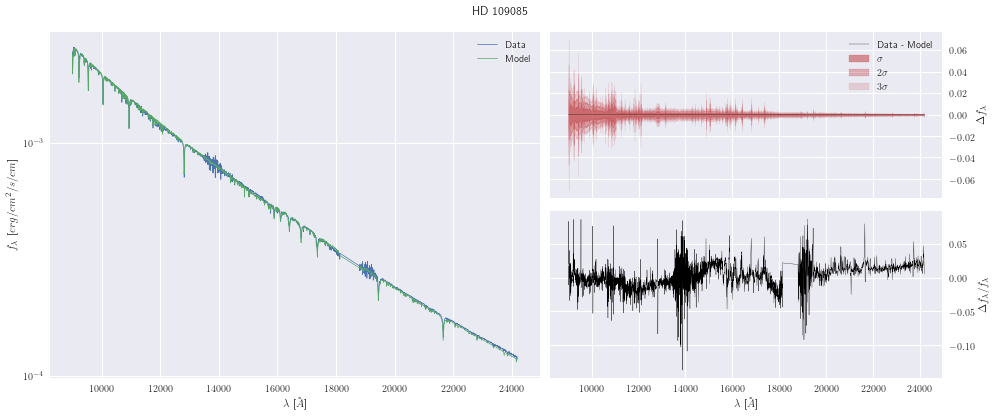

In [21]:
model.plot();

## Instantiate local kernels

Now we want to take our residuals and put some local kernels where we expect spectral line outliers. We can see from the previous plot obvious points, but we provide a utility that will apply a sigma-clipping algorithm to find such outliers.

In [47]:
from Starfish.models.utils import find_residual_peaks, optimize_residual_peaks

peaks = find_residual_peaks(model)

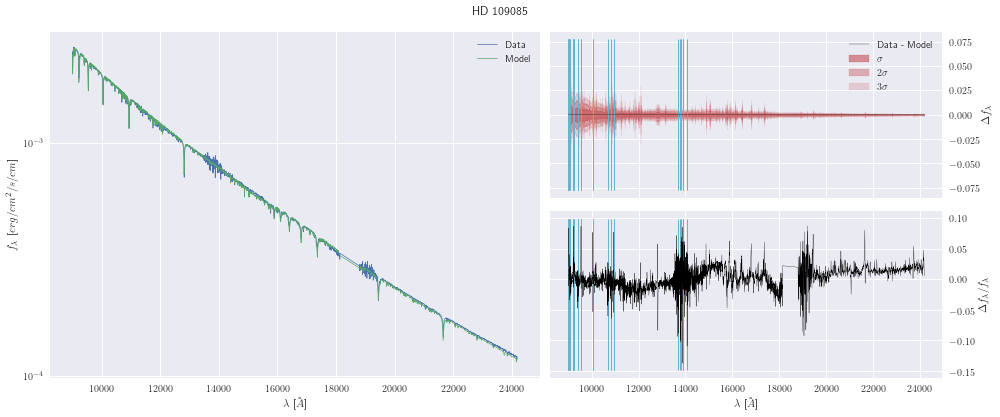

In [51]:
axes = model.plot()
lim1 = axes[1].get_ylim()
lim2 = axes[2].get_ylim()
for peak in peaks:
    axes[1].vlines(peak, *lim1, lw=1, color="C5")
    axes[2].vlines(peak, *lim2, lw=1, color="C5")

Now, we take these peaks and run them through an optimization scheme that fits the residuals (top right plot) with gaussians, and instantiates a kernel at each. If the fit kernel has too small of an amplitude, it is removed from the output. This can be useful in cases where sampling over each local kernel is too detrimental to the run time, especially considering they are an optional nuisance parameter.

In [59]:
local = optimize_residual_peaks(model, peaks)
model["local_cov"] = local
model.freeze("local_cov")

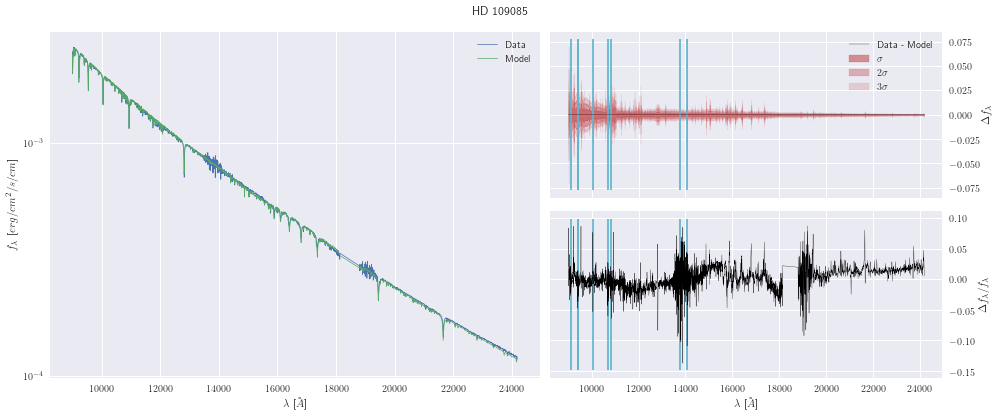

In [60]:
axes = model.plot()
lim1 = axes[1].get_ylim()
lim2 = axes[2].get_ylim()
for kernel in local:
    axes[1].vlines(kernel["mu"], *lim1, color="C5")
    axes[2].vlines(kernel["mu"], *lim2, color="C5")

Now, let's save a snapshot of our model before we begin sampling

In [61]:
model.save("HD109185_MAP.toml")

## MCMC Sampling

Now, we will sample from our model. Note the flexibility we provide with *Starfish* in order to allow sampler front-end that allows blackbox likelihood methods. In our case, we will continue with [emcee](https://github.com/dfm/emcee), which provides an ensemble sampler. We are using pre-release of version `3.0`.

This document serves only as an example, and details about emcee's usage should be sought after in its [documentation](https://emcee.readthedocs.io/en/latest/).

In [62]:
import emcee
emcee.__version__

'3.0rc2'

In [73]:
model.load("HD109185_MAP.toml")

In [74]:
# Set our walkers and dimensionality
nwalkers = 50
ndim = len(model.labels)

# Initialize gaussian ball for starting point of walkers
scales = {
    "T": 1,
    "Z": 0.01,
    "Av": 0.01,
    "global_cov:log_amp": 0.01,
    "global_cov:log_ls": 0.01,
}

ball = np.random.randn(nwalkers, ndim)

for i, key in enumerate(model.labels):
    ball[:, i] *= scales[key]
    ball[:, i] += model[key]

In [80]:
# our objective to maximize
def log_prob(P, priors):
    model.set_param_vector(P)
    return model.log_likelihood(priors)


# Set up our backend and sampler
backend = emcee.backends.HDFBackend("HD109185_chain.hdf5")
backend.reset()
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(priors,), backend=backend
)

here we start our sampler, and following [this example](https://emcee.readthedocs.io/en/latest/tutorials/monitor/#saving-monitoring-progress) we check every 10 steps for convergence, with a max burn-in of 1000 samples.

<div class="alert alert-warning">

**Warning:** This is something that can take many hours to complete. We recommend using a server to complete these computations. An ideal setup would have a jupyter server running such that we can avoid writing any scripts and transferring any data.

</div>

In [ ]:
max_n = 1000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf


# Now we'll sample for up to max_n steps
for sample in sampler.sample(ball, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 10:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 10 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        print(f"Converged at sample {sampler.iteration}")
        break
    old_tau = tau

  1%|          | 10/1000 [05:52<10:59:08, 39.95s/it]/Users/miles/.pyenv/versions/3.7.0/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less
/Users/miles/.pyenv/versions/3.7.0/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less
  5%|▌         | 50/1000 [39:16<13:25:00, 50.84s/it]

After our model has converged, let's take a few extra samples to make sure we have clean chains

In [ ]:
pos = backend.get_last_sample()
sampler.run_mcmc(None, 100, progress=True)

## MCMC Chain Analysis

Chain analysis is a very broad topic that is mostly out of the scope of this example. 
For our analysis, we like using [ArviZ](https://github.com/arviz-devs/arviz) with a simple [corner](https://github.com/dfm/corner.py) plot as well. 

In [ ]:
import arviz as az
import corner

print(az.__version__, corner.__version__)

In [ ]:
reader = emcee.backends.HDF5Backend("HD109185_chain.hdf5")
full_data = az.from_emcee(reader, var_names=model.labels)

In [ ]:
az.plot_trace(full_data);

After seeing our full traces, let's discard and thin some of the burn-in

In [ ]:
tau = reader.get_autocorr_time(tol=0)
burnin = int(2 * tau.max())
thin = int(0.5 * np.min(tau))
burn_samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

dd = dict(zip(model.labels, burn_samples.T))
burn_data = az.from_dict(dd)

In [ ]:
az.plot_trace(burn_data);

In [ ]:
az.summary(burn_data)

In [ ]:
az.plot_posterior(burn_data, ["T", "Z", "Av"]);

In [ ]:
# See https://corner.readthedocs.io/en/latest/pages/sigmas.html#a-note-about-sigmas
sigmas = ((1 - np.exp(-0.5)), (1 - np.exp(-2)))
cornor.cornor(
    burm_samples, labels=model.labels, quantiles=(0.05, 0.16, 0.84, 0.95), levels=sigmas
);

After looking at our posteriors, let's look at our fit

In [ ]:
best_fit = dict(zip(labels, chain.mean((1, 2))))
model.set_param_dict(best_fit)
model

In [ ]:
model.plot()

and finally, we can save our best fit.

In [ ]:
model.save("HD109185_sampled.toml")

Now, on to the next star!